In [2]:
def get_data_key_from_filename(filename):
    filename = filename.split("/")
    filename = filename[-1].split(".")
    filename = filename[0].split("_")
    filename = filename[2:]
    filename[-1] = filename[-1].lstrip("0")
    return "_".join(filename)

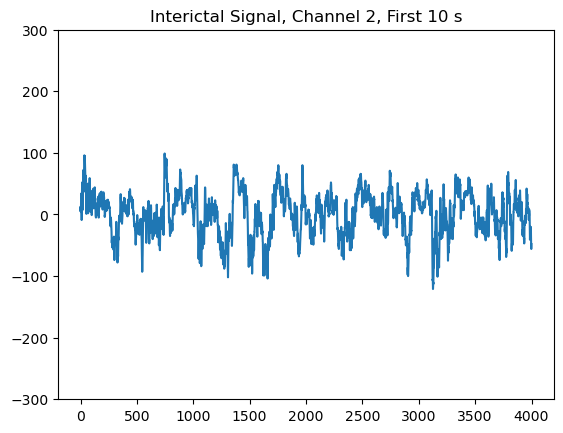

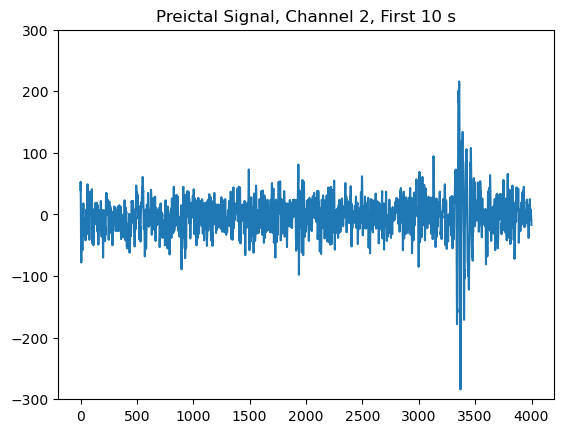

In [4]:
import matplotlib.pyplot as plt
# from feature_extraction import get_data_key_from_filename
import os
from scipy.io import loadmat
import numpy as np

root_folder = "/Volumes/Backup Plus/My files/Emory MS/ML final proj/seizure-prediction"
train_interictal_file = "Dog_1/Dog_1/Dog_1_interictal_segment_0009.mat"
train_preictal_file = "Dog_1/Dog_1/Dog_1_preictal_segment_0013.mat"

filepath = os.path.join(root_folder, train_interictal_file)
mat_data = loadmat(filepath)
signals_interictal = np.array(mat_data[get_data_key_from_filename(train_interictal_file)][0, 0][0])
signals_interictal = np.transpose(signals_interictal)   # convert so # timepoints x # channels
filepath = os.path.join(root_folder, train_preictal_file)
mat_data = loadmat(filepath)
signals_preictal = np.array(mat_data[get_data_key_from_filename(train_preictal_file)][0, 0][0])
signals_preictal = np.transpose(signals_preictal)   # convert so # timepoints x # channels

plt.plot(signals_interictal[0:4000, 1])
plt.title("Interictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()
plt.plot(signals_preictal[0:4000, 1])
plt.title("Preictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()

239766
3766
(236000, 16)
(236000, 16)
Interictal Tensor Shape: (59, 4000, 16)
Preictal Tensor Shape: (59, 4000, 16)


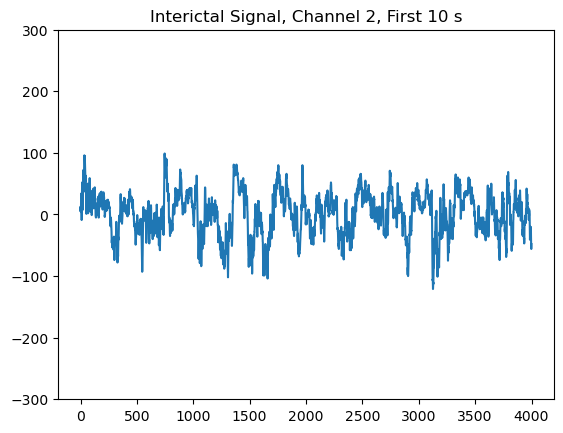

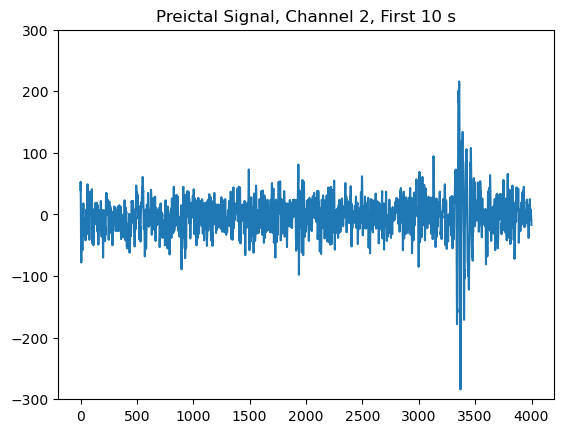

X shape: (118, 4000, 16)
y shape: (118,)


In [6]:
# create tensors
import tensorflow as tf
import torch

WINDOW_SIZE = 4000  # sample count, approximately 10 s
NUM_CHANNELS = 16

extra_rows_interictal = signals_interictal.shape[0] % WINDOW_SIZE
print(signals_interictal.shape[0])
print(extra_rows_interictal)
# exclude last segment if < WINDOW_SIZE
if extra_rows_interictal > 0:
    signals_interictal = signals_interictal[:-extra_rows_interictal, :]
print(signals_interictal.shape)

extra_rows_preictal = signals_preictal.shape[0] % WINDOW_SIZE
# exclude last segment if < WINDOW_SIZE
if extra_rows_preictal > 0:
    signals_preictal = signals_preictal[:-extra_rows_preictal, :]
print(signals_preictal.shape)

windowed_interictal = signals_interictal.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)
windowed_preictal = signals_preictal.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)

print(f"Interictal Tensor Shape: {windowed_interictal.shape}")
print(f"Preictal Tensor Shape: {windowed_preictal.shape}")

plt.plot(windowed_interictal[0, :, 1])
plt.title("Interictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()
plt.plot(windowed_preictal[0, :, 1])
plt.title("Preictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()

X = np.concatenate( (windowed_interictal, windowed_preictal) )
y = np.concatenate( (np.zeros(windowed_interictal.shape[0],), np.ones(windowed_preictal.shape[0],)) )
print(f"X shape: {X.shape}") #shape (num_samples, window_size, num_channels)
print(f"y shape: {y.shape}")

# Define DDPM

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Assuming you have your X and y data ready
X_normalized = (X - X.min()) / (X.max() - X.min())

In [17]:
X_tensor.size()

torch.Size([118, 4000, 16])

In [22]:
# Define the Denoising Diffusion Probabilistic Model (DDPM)
class DDPM(nn.Module):
    def __init__(self, input_channels, num_filters):
        super(DDPM, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv1d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output range between 0 and 1
        )
        
    def forward(self, x):
        #encoded = self.encoder(x)
        encoded = self.encoder(x.permute(0, 2, 1))  # Permute to match Conv1d input format
        decoded = self.decoder(encoded)
        #return decoded
        return decoded.permute(0, 2, 1)  # Permute back to original shape

# Hyperparameters
input_channels = 16  # NUM_CHANNELS

num_filters = 32
batch_size = 8  # Reducing batch size for demonstration purposes
learning_rate = 0.001
num_epochs = 10

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # Assuming y contains float labels

# Create a DataLoader for handling batches during training
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = DDPM(input_channels, num_filters)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (batch_X, _) in enumerate(dataloader):
        
        # Forward pass
        reconstructed = model(batch_X)
        
        # Calculate loss
        loss = criterion(reconstructed, batch_X)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")

# Generate synthetic data samples
num_samples_to_generate = 10
with torch.no_grad():
    generated_samples = []
    for _ in range(num_samples_to_generate):
        noise = torch.randn(1, X.shape[1], 32)  # Generate noise with 32 channels
        generated = model.decoder(noise.permute(0, 2, 1)).squeeze().numpy()  # Adjust input shape for the decoder
        generated_samples.append(generated)

# Convert generated samples to a NumPy array
generated_samples = np.array(generated_samples)

Epoch [1/10], Batch [1/15], Loss: 0.00482662720605731
Epoch [1/10], Batch [2/15], Loss: 0.004445583093911409
Epoch [1/10], Batch [3/15], Loss: 0.004255968611687422
Epoch [1/10], Batch [4/15], Loss: 0.003939250949770212
Epoch [1/10], Batch [5/15], Loss: 0.0036003447603434324
Epoch [1/10], Batch [6/15], Loss: 0.003217915538698435
Epoch [1/10], Batch [7/15], Loss: 0.003062432399019599
Epoch [1/10], Batch [8/15], Loss: 0.0024140754248946905
Epoch [1/10], Batch [9/15], Loss: 0.002052636118605733
Epoch [1/10], Batch [10/15], Loss: 0.0018253130838274956
Epoch [1/10], Batch [11/15], Loss: 0.0014751134440302849
Epoch [1/10], Batch [12/15], Loss: 0.001395625527948141
Epoch [1/10], Batch [13/15], Loss: 0.0011134302476420999
Epoch [1/10], Batch [14/15], Loss: 0.0011950068874284625
Epoch [1/10], Batch [15/15], Loss: 0.0012846951140090823
Epoch [2/10], Batch [1/15], Loss: 0.0011506734881550074
Epoch [2/10], Batch [2/15], Loss: 0.0008723139180801809
Epoch [2/10], Batch [3/15], Loss: 0.000735371257178

Epoch [10/10], Batch [15/15], Loss: 0.0003625885583460331


In [23]:
generated_samples

array([[[0.43135017, 0.40322465, 0.5172444 , ..., 0.5807287 ,
         0.6343249 , 0.52239096],
        [0.50238556, 0.5014469 , 0.4974136 , ..., 0.6575589 ,
         0.52544576, 0.47251618],
        [0.5388986 , 0.48767972, 0.51732457, ..., 0.60556227,
         0.5910025 , 0.4849806 ],
        ...,
        [0.5199753 , 0.57016665, 0.61780304, ..., 0.61710656,
         0.6330143 , 0.57055515],
        [0.51341265, 0.5705364 , 0.56373566, ..., 0.6131867 ,
         0.69278437, 0.5787085 ],
        [0.535757  , 0.5206214 , 0.5765341 , ..., 0.61566085,
         0.6239051 , 0.5337675 ]],

       [[0.47689962, 0.44765666, 0.5515895 , ..., 0.47249925,
         0.5860001 , 0.5173534 ],
        [0.57849455, 0.5615145 , 0.50424904, ..., 0.54180706,
         0.53635263, 0.5512931 ],
        [0.545556  , 0.54747534, 0.49721202, ..., 0.59390694,
         0.5042908 , 0.5041735 ],
        ...,
        [0.53626287, 0.6015929 , 0.60851234, ..., 0.5384353 ,
         0.6272633 , 0.55615073],
        [0.5

In [29]:
generated_samples.shape #shape (num_samples, window_size, num_channels); window_size and num_channels is reversed

(10, 16, 4000)

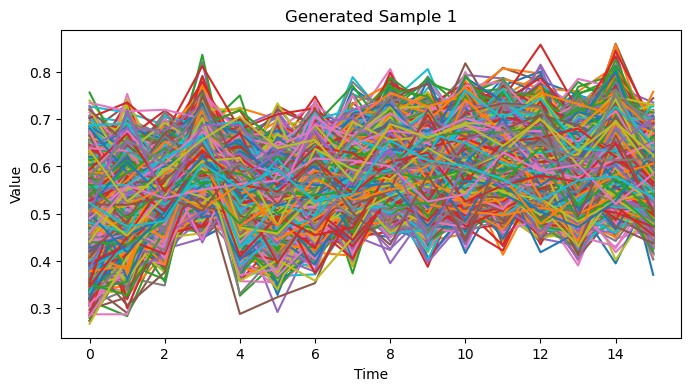

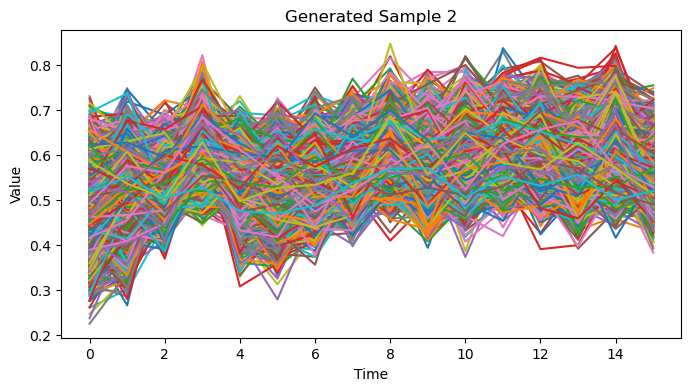

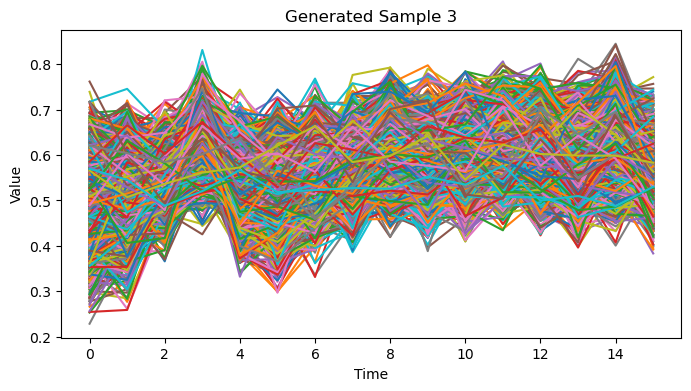

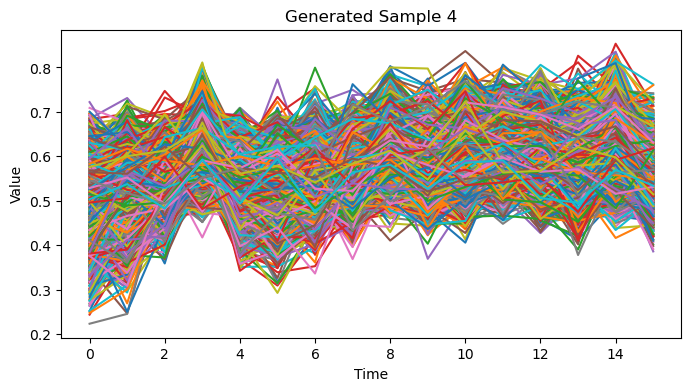

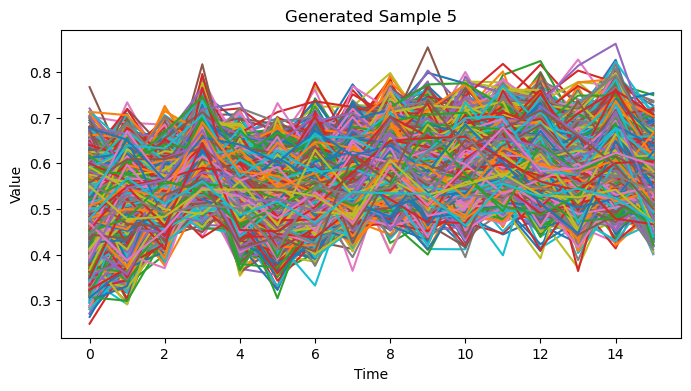

In [24]:
import matplotlib.pyplot as plt

# Assuming generated_samples is a NumPy array containing generated samples
# Visualizing a few generated samples (adjust indices as needed)
num_samples_to_visualize = 5

for i in range(num_samples_to_visualize):
    plt.figure(figsize=(8, 4))
    plt.plot(generated_samples[i])
    plt.title(f"Generated Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()


In [26]:
# Calculate mean and standard deviation of generated samples
mean_values = np.mean(generated_samples, axis=1)
std_values = np.std(generated_samples, axis=1)
print(mean_values, std_values)

[[0.5216713  0.54360557 0.5359639  ... 0.6017967  0.64420444 0.559555  ]
 [0.5363848  0.5552153  0.61503625 ... 0.57448536 0.57034415 0.5236912 ]
 [0.51379704 0.5554396  0.52831227 ... 0.58146304 0.58770084 0.5297073 ]
 ...
 [0.5440906  0.5411383  0.5458076  ... 0.5823978  0.5565893  0.56041616]
 [0.53804845 0.5299017  0.5367724  ... 0.54339874 0.5120432  0.5343416 ]
 [0.5442135  0.57521886 0.5807916  ... 0.6049078  0.5811123  0.53927684]] [[0.03571879 0.06185327 0.05720947 ... 0.029263   0.04803463 0.04679101]
 [0.03048093 0.06001902 0.06452091 ... 0.05038944 0.05265394 0.03068561]
 [0.02956605 0.03931089 0.05481425 ... 0.05215877 0.0387056  0.02628645]
 ...
 [0.03223534 0.04054616 0.03758899 ... 0.08829937 0.06866314 0.05992562]
 [0.04449963 0.02498951 0.04194942 ... 0.062332   0.07614192 0.07218734]
 [0.04452138 0.06870445 0.07990339 ... 0.03995745 0.03813851 0.03155443]]
